In [63]:
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from numpy import newaxis, concatenate
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error
from pandas import read_csv, DataFrame,concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

In [64]:
seq_len = 1
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
def predict_sequences_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, window_size-1,predicted[-1], axis=0)
    return predicted

In [65]:
#
dataset = read_csv('stock1.csv', header = 0, index_col=0)
dataset_stock = read_csv('stock1.csv', header = 0, index_col=0)
values = dataset.values
values_stock = dataset_stock.values
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
values_stock[:,0] = encoder.fit_transform(values_stock[:,0])
values = values.astype('float32')
values_stock = values_stock.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled_stock = scaler.fit_transform(values_stock)
reframed = series_to_supervised(scaled, 1, 1)
reframed_stock = series_to_supervised(scaled_stock, 1, 1)
print(reframed.head())
print(reframed_stock.head())

   var1(t-1)   var1(t)
1   0.157798  0.161468
2   0.161468  0.150459
3   0.150459  0.177982
4   0.177982  0.166972
5   0.166972  0.179817
   var1(t-1)   var1(t)
1   0.157798  0.161468
2   0.161468  0.150459
3   0.150459  0.177982
4   0.177982  0.166972
5   0.166972  0.179817


In [66]:
values = reframed.values
values_stock = reframed_stock.values
n_train_hours = 50
n_end = n_train_hours + 5
train = values[:n_train_hours, :]
train_stock = values_stock[:n_train_hours,:]
test = values[n_train_hours:n_end :]
test_stock = values_stock[n_train_hours:n_end:]
train_X, train_y = train[:,:-1], train[:, -1]
train_stock_X, train_stock_y = train_stock[:,:-1], train_stock[:, -1]
test_X, test_y = test[:, :-1], test[:,-1]
test_stock_X, test_stock_y = test_stock[:, :-1], test_stock[:,-1] 
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_stock_X = train_stock_X.reshape((train_stock_X.shape[0], 1, train_stock_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0],1, test_stock_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_stock_X.shape, train_stock_y.shape, test_stock_X.shape, test_stock_y.shape)

(50, 1, 1) (50,) (5, 1, 1) (5,)
(50, 1, 1) (50,) (5, 1, 1) (5,)


In [67]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
start = time.time()
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
print("> Compilation Time :", time.time() - start)
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#print (seq_len)
predicted = predict_sequences_full(model, test_X, seq_len)

> Compilation Time : 0.0225372314453125
Train on 50 samples, validate on 5 samples
Epoch 1/50
1s - loss: 0.0034 - val_loss: 0.0051
Epoch 2/50
0s - loss: 7.8403e-04 - val_loss: 0.0039
Epoch 3/50
0s - loss: 8.6272e-04 - val_loss: 0.0040
Epoch 4/50
0s - loss: 7.4403e-04 - val_loss: 0.0037
Epoch 5/50
0s - loss: 8.1904e-04 - val_loss: 0.0034
Epoch 6/50
0s - loss: 7.4600e-04 - val_loss: 0.0035
Epoch 7/50
0s - loss: 7.1839e-04 - val_loss: 0.0032
Epoch 8/50
0s - loss: 8.6620e-04 - val_loss: 0.0033
Epoch 9/50
0s - loss: 6.9137e-04 - val_loss: 0.0029
Epoch 10/50
0s - loss: 7.7741e-04 - val_loss: 0.0024
Epoch 11/50
0s - loss: 8.2175e-04 - val_loss: 0.0028
Epoch 12/50
0s - loss: 6.6928e-04 - val_loss: 0.0028
Epoch 13/50
0s - loss: 7.9272e-04 - val_loss: 0.0027
Epoch 14/50
0s - loss: 6.9361e-04 - val_loss: 0.0026
Epoch 15/50
0s - loss: 6.7095e-04 - val_loss: 0.0027
Epoch 16/50
0s - loss: 5.2528e-04 - val_loss: 0.0019
Epoch 17/50
0s - loss: 6.3768e-04 - val_loss: 0.0025
Epoch 18/50
0s - loss: 6.2652

[0.078671925, 0.082755066, 0.084304884, 0.084893644, 0.085117385]
5


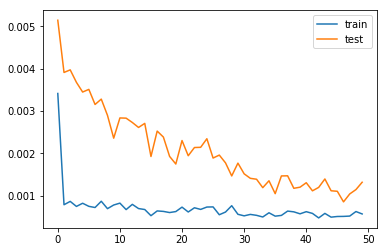

In [68]:
print (predicted)
l = len(predicted)
print (l)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

[ 0.07867192  0.08275507  0.08430488  0.08489364  0.08511738] [ 0.06238532  0.03853211  0.02018349  0.0146789   0.03669725]
MSE: 0.002721


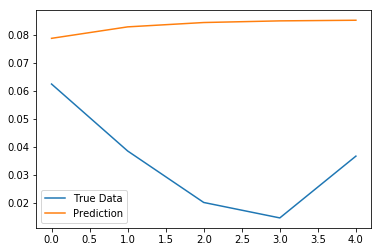

In [69]:
#yhat =  model.predict(test_X)
predicted = np.reshape(predicted, (l,))
#print('Training duration (s):', time.time() - global_start_time)
#test_stock_y = scaler.inverse_transform(test_stock_y)
#predicted = scaler.inverse_transform(predicted)
print(predicted, test_stock_y)
rmse = np.sqrt(((predicted - test_stock_y) ** 2).mean(axis=0))
score = mean_squared_error(predicted, test_stock_y)
    
print("MSE: %f" % score)
plot_results(predicted, test_stock_y)
#plot_results(inv_y, inv_yhat)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#print test_X[:,1:]
#print yhat
#inv_yhat = concatenate((yhat, test_X[:,1:]), axis=1)

#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]
#print inv_yhat
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis =1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

Test RMSE: 0.038


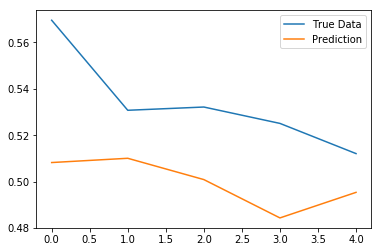

In [101]:
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)


[[[ 0.56146789]]

 [[ 0.50825691]]

 [[ 0.51009172]]

 [[ 0.50091743]]

 [[ 0.48440367]]]
[ 0.50825691  0.51009172  0.50091743  0.48440367  0.49541286] [ 0.56955498  0.53076953  0.53217107  0.52511579  0.51211256]
Test RMSE: 0.038


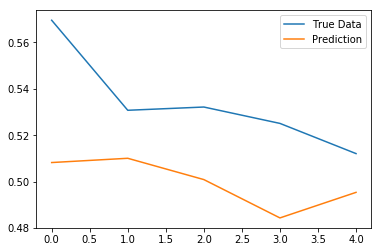

In [102]:
print test_stock_X
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0], test_stock_X.shape[2]))
test_stock_y = test_stock_y.reshape((len(test_stock_y), 1))
stock_y = concatenate((test_stock_y, test_stock_X[:, 1:]), axis =1)
stock_y = stock_y[:,0]
#print stock_y
#stock_y = stock_y * 0.002
print stock_y, inv_yhat
stock_y = scaler.inverse_transform(stock_y)
inv_yhat = scaler.inverse_transform(inv_yhat)
rmse = sqrt(mean_squared_error(stock_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plot_results(stock_y, inv_yhat)